# LAB: (quasi-) Newton methods



The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
and compare your implementation with the BFGS and L-BFGS solvers in scipy

You will need to knowledge on **line search methods** and **conjugate gradient** in particular you should reuse the notebooks presented during the lectures.


### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "daniel"
ln1 = "wamo"
fn2 = "samuel"
ln2 = "guilhem-ducléon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_wamo_daniel_and_guilhem-ducléon_samuel.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [5]:
from optim_utils import test_solver

You'll have work only with the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

Let us now make an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now I can call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


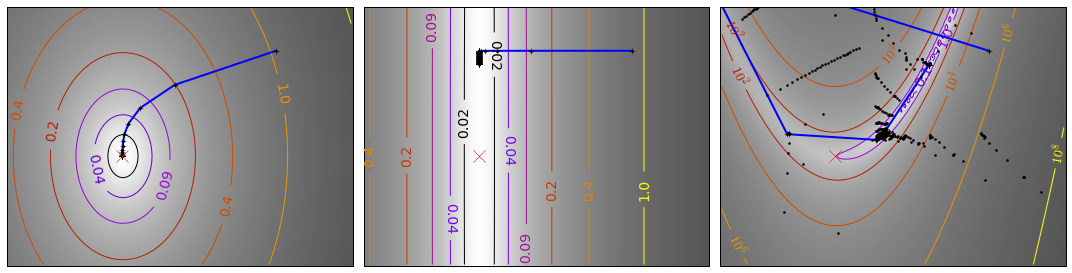

In [5]:
test_solver(gradient_descent)

# Part 1: Implement Newton method

You now need to implement Newton method using either `linalg.solve` or `sparse.linalg.cg` solve the linear system at each iteration. You need to implement both versions.

You're expected to comment in a few lines what you see.

In [6]:
import scipy.linalg as linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        ####################################
        # Compute here the search direction
        d = linalg.solve(- f_hessian(x), grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x += d
        ##################################

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 2
iter: 1, f: 0, l_inf_norm(grad): 0

Running solver on case 3
iter: 1, f: 0.357547, l_inf_norm(grad): 1.19858
iter: 2, f: 0.253454, l_inf_norm(grad): 14.6168
iter: 3, f: 2.44184e-07, l_inf_norm(grad): 0.000988318
iter: 4, f: 5.96257e-12, l_inf_norm(grad): 9.76735e-05
iter: 5, f: 4.93038e-32, l_inf_norm(grad): 4.44089e-16


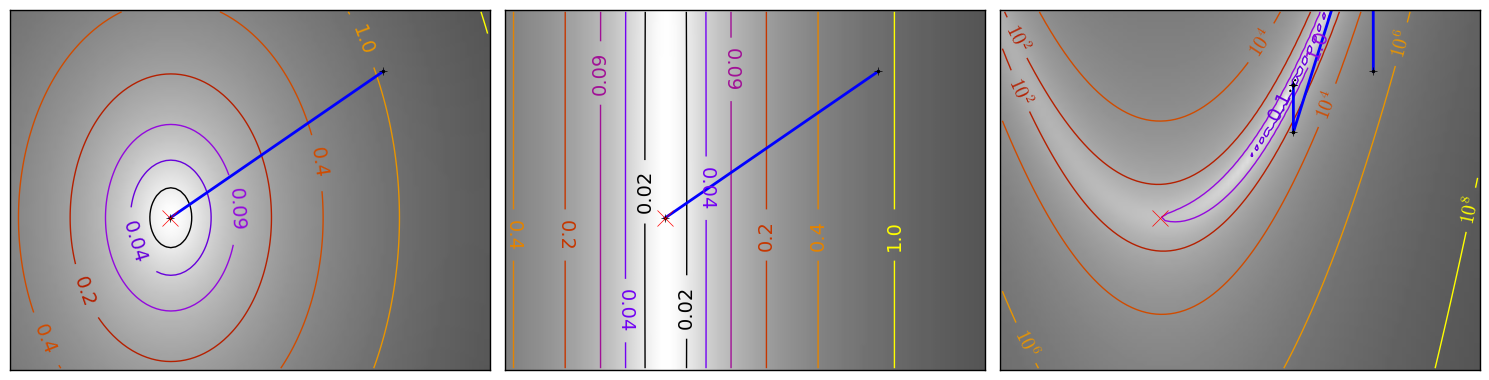

In [7]:
test_solver(newton)

It converges in one step for case 1 and case 2.

However for case 3, it requires more steps as the problem is not quadratic anymore.

# Part 2: Implement DFP algorithm

You now need to implement the DFP algorithm.

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = - B.dot(grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################
        # Compute here the new value of x
        x = x + step * d
        ##################################
        
        new_grad = f_grad(x)
        new_f = f(x)
        
        #########################################################
        # Update the inverse Hessian approximation
        s = step * d
        y = new_grad - grad_x
        
        s = s[:, None]
        y = y[:, None]
        B = B + (s.dot(s.T)) / (s.T.dot(y)) - (B.dot(y.dot(y.T.dot(B)))) / (y.T.dot(B.dot(y)))
        #########################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            pass
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' % (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0214911, l_inf_norm(grad): 0.114753
iter: 3, f: 0.00899657, l_inf_norm(grad): 0.069501
iter: 4, f: 0.00023476, l_inf_norm(grad): 0.0175216
iter: 5, f: 1.76801e-05, l_inf_norm(grad): 0.00465113
iter: 6, f: 3.20353e-08, l_inf_norm(grad): 0.000140183
iter: 7, f: 1.32183e-10, l_inf_norm(grad): 8.99094e-06
iter: 8, f: 8.82459e-15, l_inf_norm(grad): 1.04309e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000138677, l_inf_norm(grad): 0.000270594
iter: 4, f: 1.92681e-07, l_inf_norm(grad): 0.000503909
iter: 5, f: 1.4273e-07, l_inf_norm(grad): 0.000433799
iter: 6, f: 3.512e-14, l_inf_norm(grad): 1.6706e-08

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.56575, l_inf_norm(grad): 24.138
iter: 3, f: 7.34339, l_inf_norm(grad): 4.87789
iter: 4, f: 7.29892, l_inf_norm(grad): 8.4

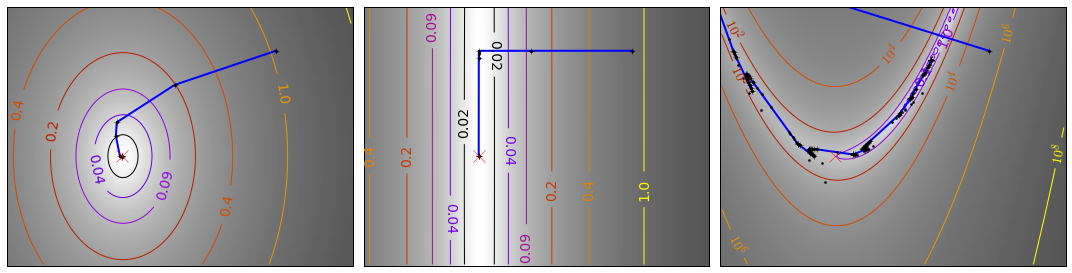

In [9]:
test_solver(dfp)

For case 2, the directions are perpendicular as the hessian matrix is the identity.
In the quadratic case, the algorithm is like a conjugate gradient method, which therefore converges in at most n
iterations.

# Part 3: Implement BFGS algorithm

You now need to implement the BFGS algorithm.

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = True

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    H = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        ####################################
        # Compute here the search direction
        d = - linalg.solve(H, grad_x)
        ####################################

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        ##################################    
        # Compute here the new value of x
        x = x + step * d
        ##################################
        
        #####################################################
        # Update the Hessian approximation
        y = new_grad - grad_x
        s = step * d
        y = y[:, None]
        s = s[:, None]
        H = H + (y.dot(y.T)) / (y.T.dot(s)) - (H.dot(s.dot(s.T.dot(H)))) / (s.T.dot(H.dot(s)))
        #####################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1
iter: 1, f: 0.187228, l_inf_norm(grad): 0.35904
iter: 2, f: 0.0209281, l_inf_norm(grad): 0.11324
iter: 3, f: 0.00806831, l_inf_norm(grad): 0.0656686
iter: 4, f: 3.9809e-05, l_inf_norm(grad): 0.00723054
iter: 5, f: 4.69973e-07, l_inf_norm(grad): 0.000735419
iter: 6, f: 7.22702e-11, l_inf_norm(grad): 6.78586e-06
iter: 7, f: 2.47614e-14, l_inf_norm(grad): 1.18656e-07

Running solver on case 2
iter: 1, f: 0.0978185, l_inf_norm(grad): 0.35904
iter: 2, f: 0.000159508, l_inf_norm(grad): 0.000290207
iter: 3, f: 0.000119306, l_inf_norm(grad): 0.00025098
iter: 4, f: 6.91982e-13, l_inf_norm(grad): 9.54949e-07

Running solver on case 3
iter: 1, f: 104.123, l_inf_norm(grad): 700.972
iter: 2, f: 7.59071, l_inf_norm(grad): 26.034
iter: 3, f: 7.34411, l_inf_norm(grad): 4.87129
iter: 4, f: 7.29555, l_inf_norm(grad): 8.30631
iter: 5, f: 6.98403, l_inf_norm(grad): 49.3631
iter: 6, f: 6.72314, l_inf_norm(grad): 26.9831
iter: 7, f: 6.31556, l_inf_norm(grad): 14.5499
iter: 8, f: 5.

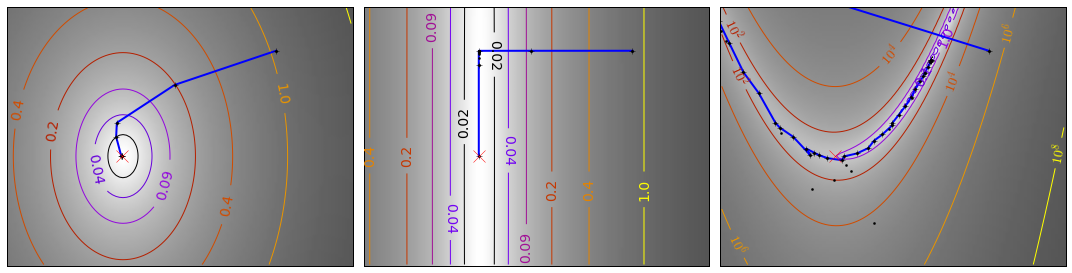

In [11]:
test_solver(bfgs)

In case 2, the convergence is also performed in 2 (4) iterations. 
The BFGS and DFP algorithm find the minimum almost the same way but the  BFGS solution is better.

# Part 4: Do the same now with scipy implementation of BFGS and L-BFGS


Running solver on case 1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7

Running solver on case 2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5
         Function evaluations: 19
         Gradient evaluations: 19

Running solver on case 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 30
         Gradient evaluations: 30


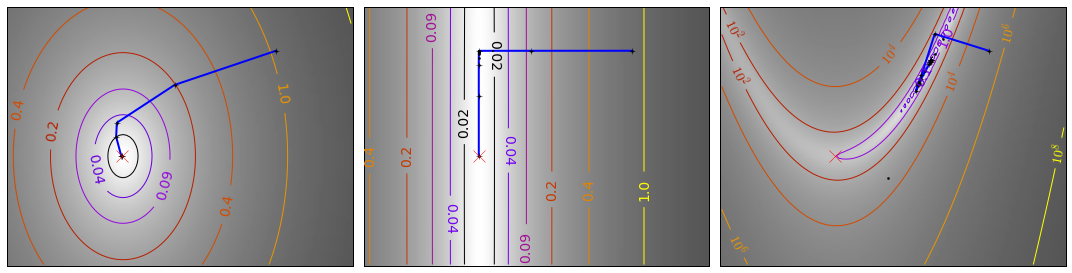

In [13]:
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b

def wrapper_bfgs(x0, f, f_grad, f_hessian):
    _, _, _, _, _, _, _, ret_list = fmin_bfgs(f, x0, fprime=f_grad, retall=True, full_output=True)
    
    all_x = ret_list
    all_f = map(f, all_x)
    
    return np.array(all_x), np.array(all_f)

test_solver(wrapper_bfgs)

the function fmin_bfgs of scipy give the same solution than your own fonction BFGS but it use less of iterations.   


Running solver on case 1

Running solver on case 2

Running solver on case 3


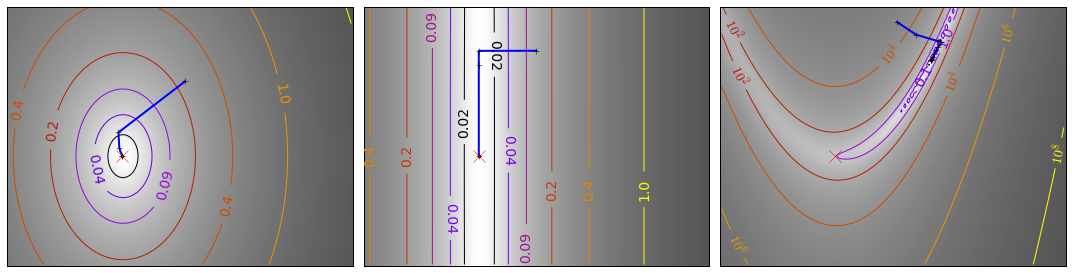

In [14]:
def wrapper_l_bfgs(x0, f, f_grad, f_hessian):
    
    all_x = []
    
    def callback(xk):
        all_x.append(xk.copy())
        
        
    _, _, _ = fmin_l_bfgs_b(f, x0, fprime=f_grad, callback=callback)
    
    all_f = map(f, all_x)
    
    return np.array(all_x), np.array(all_f)

test_solver(wrapper_l_bfgs)

In this case we see the starting point isn't the same.